# Running Queries

In [3]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:


# Set up the connection details
conn = psycopg2.connect(
    host="localhost",      # PostgreSQL server address
    database="AOL_schema",    # Replace with your database name
    user="postgres",  # Replace with your PostgreSQL username
    password="Waah9233" # Replace with your PostgreSQL password
)

In [5]:
cur = conn.cursor()

## Question 1

In [9]:
# About external data set:
'''Source : https://www.kaggle.com/datasets/justin2028/unemployment-in-america-per-us-state?resource=download
Size :  
- 11 features
- 29893 rows


Perform ETL - 
Steps:
    - Downloading from kaggle
    - Perform data transformation:
        - Reduce dimensions 
        - convert values from on standards to another
        - convert numbers from , notation to plan integer
    - Only keep the records of 3 months of 2006
    - Discard the remaining
    - Final : 6 features and 160 rows
    - Load into EMPLOYMENTSTATS Table in postrge DB

'''

'Source : https://www.kaggle.com/datasets/justin2028/unemployment-in-america-per-us-state?resource=download\nSize :  \n- 11 features\n- 29893 rows\n\n\nPerform ETL - \nSteps:\n    - Downloading from kaggle\n    - Perform data transformation:\n        - Reduce dimensions \n        - convert values from on standards to another\n        - convert numbers from , notation to plan integer\n    - Only keep the records of 3 months of 2006\n    - Discard the remaining\n    - Final : 6 features and 160 rows\n    - Load into EMPLOYMENTSTATS Table in postrge DB\n\n'

In [11]:
query='''SELECT 
    * 
FROM 
    (
    SELECT
        E.state,
        E.month,
        SUM(E.unemployment) AS total_unemployment
    FROM EMPLOYMENTSTATS E
    GROUP BY GROUPING SETS(
                            (E.state, E.month)
                            )     
    ) AS subquery
ORDER BY total_unemployment DESC, month, state;
'''

query='''
SELECT 
    subquery.state,
    subquery.month,
    subquery.total_unemployment,
    t.year
FROM 
    (
        SELECT
            E.state,
            E.month,
            SUM(E.unemployment) AS total_unemployment
        FROM EMPLOYMENTSTATS E
        GROUP BY GROUPING SETS(
                                (E.state, E.month)
                                )     
    ) AS subquery
JOIN (
    SELECT DISTINCT ON (month) month, year
    FROM timedim
    ORDER BY month, year DESC
) AS t
    ON subquery.month = t.month
ORDER BY 
    subquery.total_unemployment DESC, 
    subquery.month, 
    subquery.state;
'''
df = pd.read_sql_query(query, conn)

C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_15048\621186294.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [12]:
df.head(25)

,state,month,total_unemployment,year
0,California,3,865781.0,2006
1,California,5,864854.0,2006
2,California,4,864066.0,2006
3,Texas,5,590193.0,2006
4,Texas,4,589958.0,2006
5,Texas,3,588145.0,2006
6,New York,3,447854.0,2006
7,New York,4,446317.0,2006
8,New York,5,444317.0,2006
9,Michigan,5,355061.0,2006


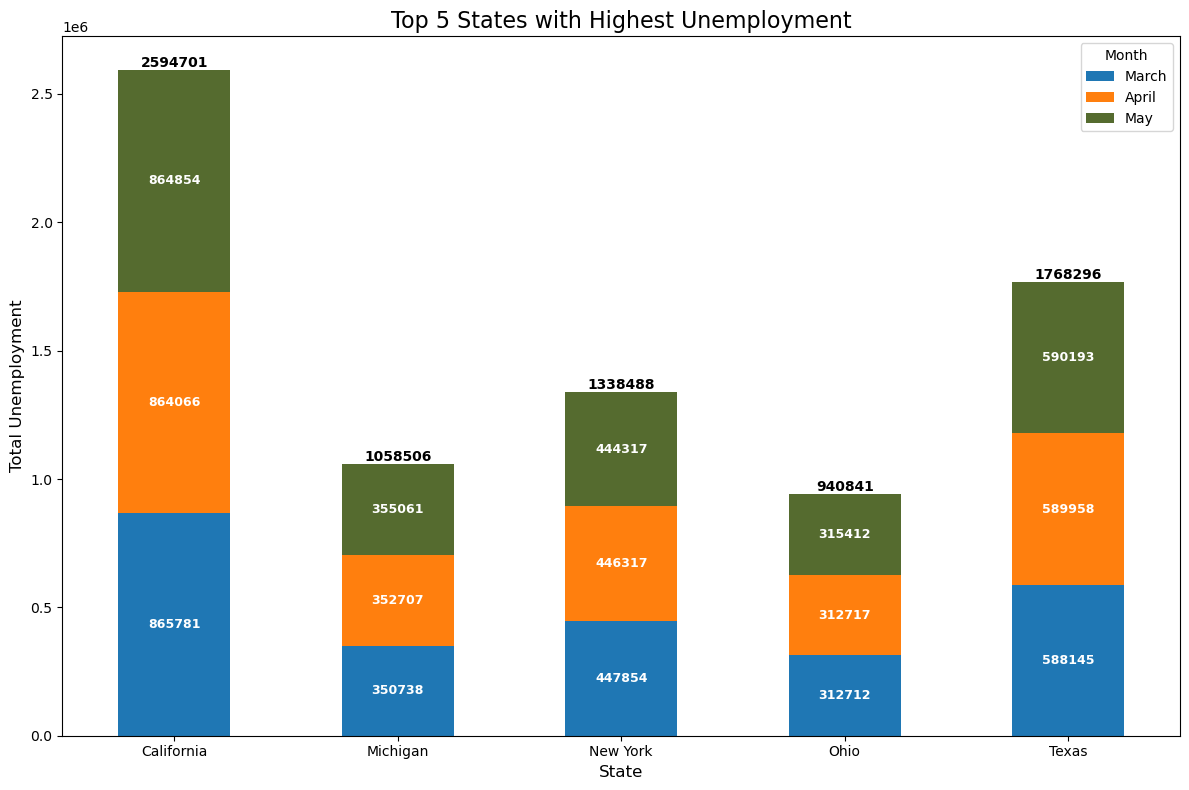

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Subset the DataFrame to include only the top 15 rows
df = df.head(15)

# Pivot DataFrame for visualization
df_pivot = df.pivot(index='state', columns='month', values='total_unemployment')

# Map numeric months to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
df_pivot.columns = [month_names[month] for month in df_pivot.columns]

# Define custom colors for the months (manual assignment)
custom_colors = ['#1f77b4', '#ff7f0e', '#556B2F', '#7f7f7f', '#9467bd', '#8c564b', 
                 '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Add as many colors as required

# Limit colors to the number of months in the data
custom_colors = custom_colors[:len(df_pivot.columns)]

# Plot using the updated colors and months
ax = df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=custom_colors
)

# Annotate total unemployment values on top of each stacked bar
for idx, state in enumerate(df_pivot.index):
    total = df_pivot.loc[state].sum()  # Calculate the total unemployment for each state
    ax.text(
        idx, 
        total + 1,  # Position slightly above the top of the bar
        f'{int(total)}',  # Convert to integer for cleaner display
        ha='center', 
        va='bottom', 
        fontsize=10, 
        fontweight='bold', 
        color='black'
    )

# Annotate individual monthly unemployment values on the bars
for idx, state in enumerate(df_pivot.index):
    cumulative_height = 0  # Tracks the cumulative height of stacked bars
    for month, value in df_pivot.loc[state].items():
        cumulative_height += value
        ax.text(
            idx, 
            cumulative_height - value / 2,  # Position at the middle of the bar segment
            f'{int(value)}',  # Convert to integer for cleaner display
            ha='center', 
            va='center', 
            fontsize=9, 
            color='white',
            fontweight='bold'
        )

# Customize the plot
plt.title("Top 5 States with Highest Unemployment", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Total Unemployment", fontsize=12)
plt.legend(title="Month", fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


## Question 2

In [84]:

# Define the SQL query
sql_query = """
select 
month,
WEEK,
count(query)
from facts fa
left join (
			select
			id,
			month,
			weekday,
			CASE
				WHEN day_of_month in (1,2,3,4,5,6,7) then 'FIRST_WEEK'
				WHEN day_of_month in (8,9,10,11,12,13,14) then 'SECOND_WEEK'
				WHEN day_of_month in (15,16,17,18,19,20,21) then 'THIRD_WEEK'
				WHEN day_of_month in (22,23,24,25,26,27,28) then 'FOURTH_WEEK'
				ELSE 'FOURTH_WEEK'
			END WEEK
			from TIMEDIM
			order by month
) tim on (fa.timeid = tim.id)
left join querydim qu on (fa.queryid = qu.id)
where UPPER(query )LIKE '%EMPLOYMENT%' OR  
	  UPPER(query )LIKE '%CAREER%' OR
	  UPPER(query )LIKE '%JOB%' OR
	  UPPER(query )LIKE '%VACANCY%'
 group by ROLLUP (month,WEEK)
 order by month,WEEK
 ;
"""
df = pd.read_sql_query(sql_query, conn)

C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\1900272771.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [85]:
df.head(15)

,month,week,count
0,3.0,FIRST_WEEK,2536
1,3.0,FOURTH_WEEK,3159
2,3.0,SECOND_WEEK,2746
3,3.0,THIRD_WEEK,2588
4,3.0,None,11029
5,4.0,FIRST_WEEK,1887
6,4.0,FOURTH_WEEK,2026
7,4.0,SECOND_WEEK,1585
8,4.0,THIRD_WEEK,1537
9,4.0,None,7035


C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\1212576566.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['week'] = pd.Categorical(df_weekly['week'], categories=week_order, ordered=True)


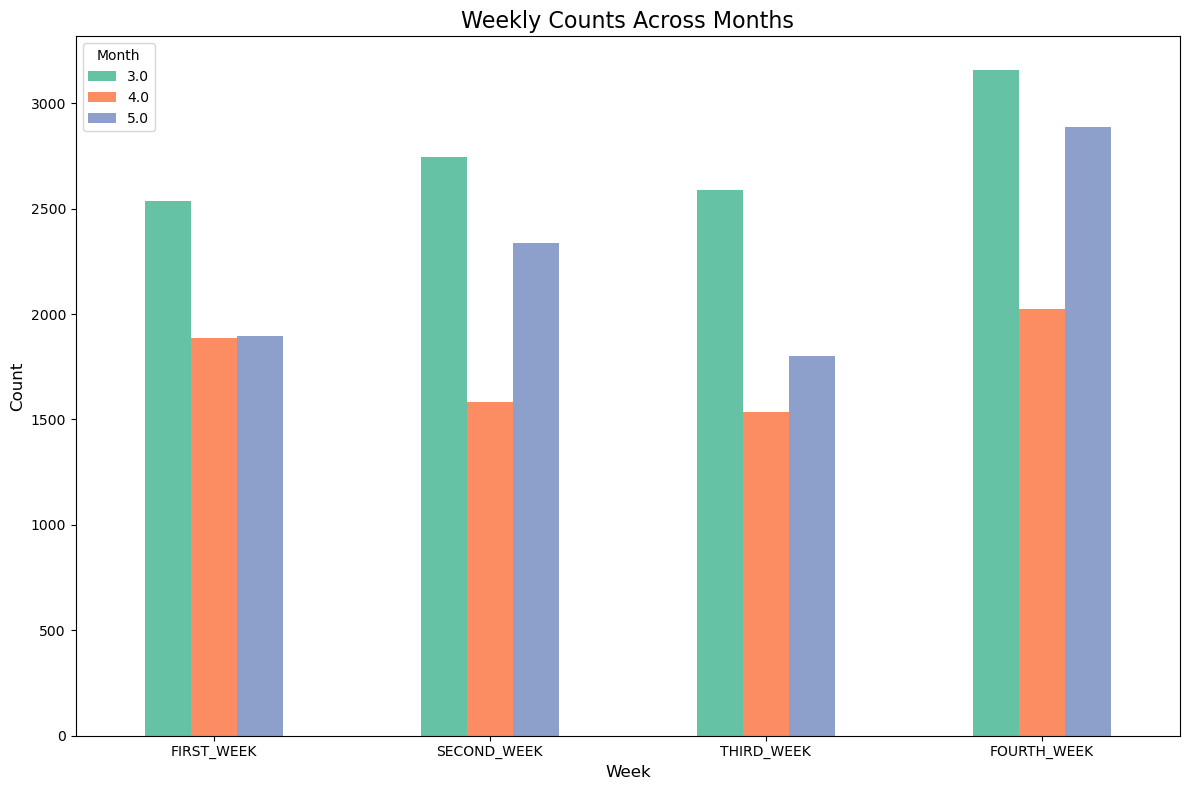

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Filter out rows with 'None' in the 'week' column for better visualization
df_weekly = df[df['week'].notna()]

# Set a custom order for the 'week' column
week_order = ["FIRST_WEEK", "SECOND_WEEK", "THIRD_WEEK", "FOURTH_WEEK"]
df_weekly['week'] = pd.Categorical(df_weekly['week'], categories=week_order, ordered=True)

# Pivot data for grouped bar chart
pivot_df = df_weekly.pivot(index='week', columns='month', values='count')

# Plot grouped bar chart
colors = sns.color_palette("Set2", n_colors=len(pivot_df.columns))

pivot_df.plot(
    kind='bar',
    figsize=(12, 8),
    color=colors
)

# Customize the plot
plt.title("Weekly Counts Across Months", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Month", fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\4143218483.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\4143218483.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


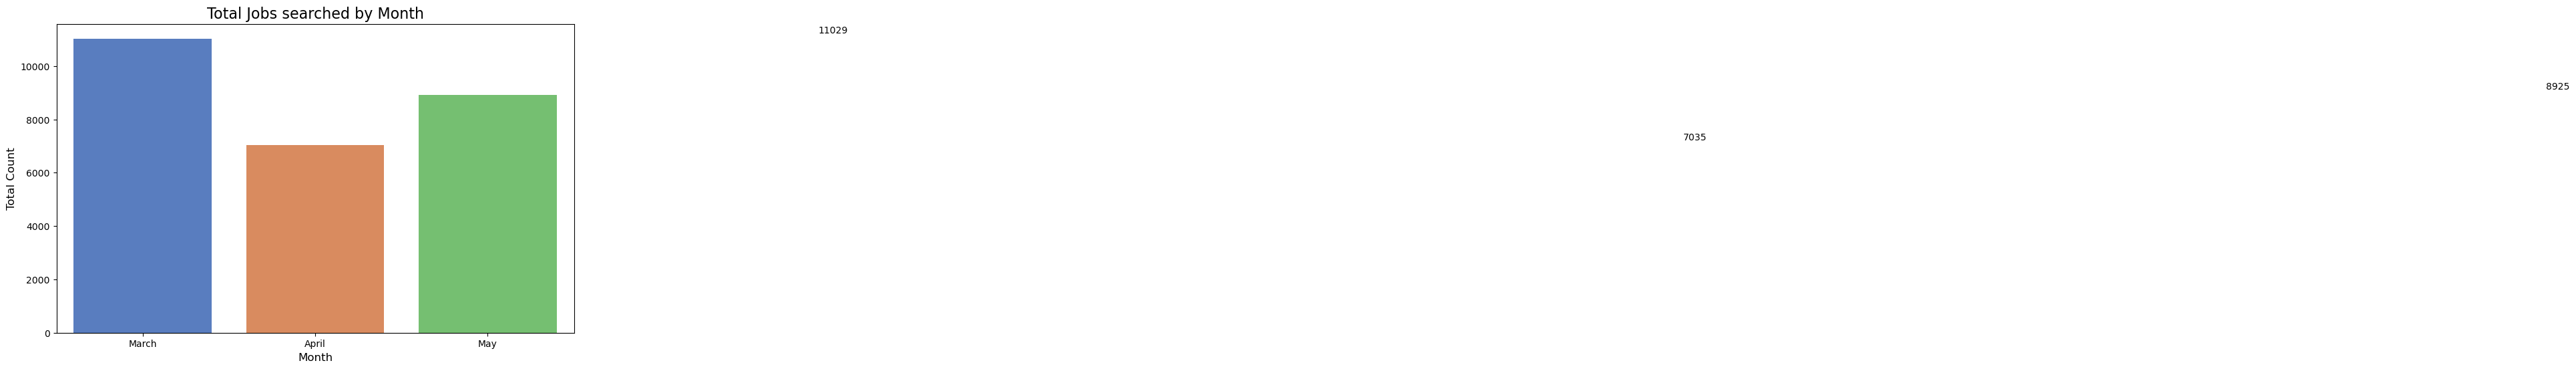

In [90]:
df_totals = df[df['week'].isna()]
df_filtered=df_totals[df_totals['month'].notna()]

# Bar plot for total counts
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtered,
    x='month',
    y='count',
    palette='muted'
)

# Add labels above bars
for index, row in df_filtered.iterrows():
    plt.text(
        x=index,  # Position text at the center of the bar
        y=row['count'] + 200,  # Position above the bar
        s=int(row['count']),
        ha='center',
        fontsize=10,
        color='black'
    )

# Customize plot
plt.title("Total Jobs searched by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Count", fontsize=12)
plt.xticks(ticks=range(len(df_filtered)), labels=['March', 'April', 'May'], fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Question 3

In [33]:
query3='''select 
month,
day_of_month,
PROFESSION,
count(PROFESSION)
from facts fa
left join (
			select
			id,
			month,
			day_of_month
			from TIMEDIM
			order by month
) tim on (fa.timeid = tim.id)
left join (
			select id ,
			CASE
				WHEN UPPER(query) LIKE '%DEVELOPER%' OR 
            		 UPPER(query) LIKE '%PROGRAMMER%'
				THEN 'Technology'
				WHEN 
            		 UPPER(query) LIKE '%PHARMACIST%' OR 
            		 UPPER(query) LIKE '%MEDICAL%'
				THEN 'Healthcare'	
				WHEN UPPER(query) LIKE '%ACCOUNTANT%' OR 
            		 UPPER(query) LIKE '%FINANCIAL%' 
				THEN 'Finance Role'
				ELSE 'OTHERS'
			END PROFESSION
			from querydim
) qu on (fa.queryid = qu.id)
where PROFESSION <> 'OTHERS'
    AND month IN (3) 
 group by CUBE (month,day_of_month,PROFESSION)
 order by month,day_of_month
 ;'''
df = pd.read_sql_query(query3, conn)

C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_15048\3219799446.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query3, conn)


In [34]:
df.head()

,month,day_of_month,profession,count
0,NaN,1.0,None,130
1,3.0,1.0,None,130
2,3.0,1.0,Technology,3
3,3.0,1.0,Healthcare,88
4,NaN,1.0,Technology,3
...,...,...,...,...
217,3.0,NaN,Healthcare,2361
218,NaN,NaN,Healthcare,2361
219,3.0,NaN,None,3686
220,3.0,NaN,Finance Role,1271


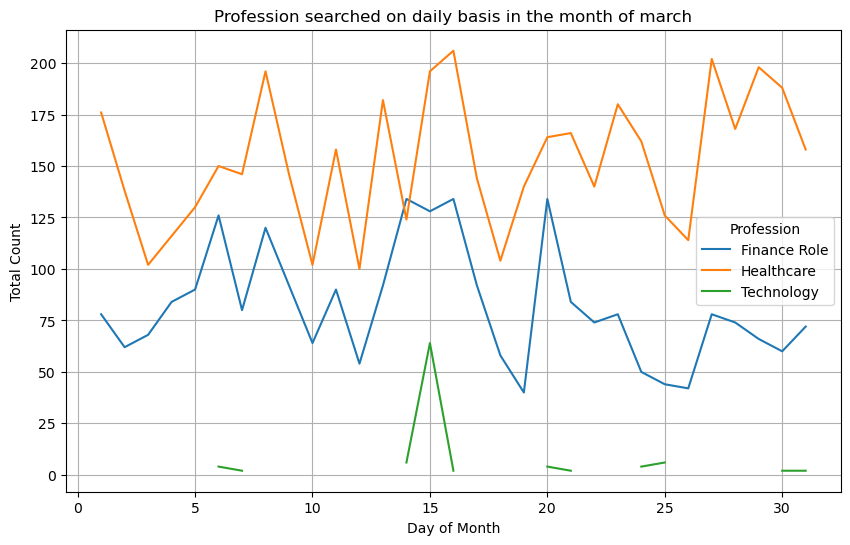

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter the data to only include the relevant professions
df_filtered = df[df['profession'].isin(['Technology', 'Healthcare', 'Finance Role'])]

# Group by day_of_month and profession, summing the counts
df_grouped = df_filtered.groupby(['day_of_month', 'profession'])['count'].sum().reset_index()

# Pivot the data so that we have one line for each profession
df_pivot = df_grouped.pivot(index='day_of_month', columns='profession', values='count')

# Plotting
plt.figure(figsize=(10, 6))
for profession in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[profession], label=profession)

# Adding labels and title
plt.xlabel('Day of Month')
plt.ylabel('Total Count')
plt.title('Profession searched on daily basis in the month of march')
plt.legend(title='Profession')

# Show the plot
plt.grid(True)
plt.show()


## Question 4

In [94]:
query4='''
WITH ProfessionClicks AS (
    select 
profession,
url,
count(click) total_clicks
from facts fa
left join (
			select
			id url_id, 
			url
			from urldim
) url on (fa.urlid = url.url_id)
left join (
			select id prof_id,
			CASE
				WHEN UPPER(query) LIKE '%DEVELOPER%' OR 
            		 UPPER(query) LIKE '%PROGRAMMER%'
				THEN 'Technology'
				WHEN 
            		 UPPER(query) LIKE '%PHARMACIST%' OR 
            		 UPPER(query) LIKE '%MEDICAL%'
				THEN 'Healthcare'	
				WHEN UPPER(query) LIKE '%ACCOUNTANT%' OR 
            		 UPPER(query) LIKE '%FINANCIAL%' 
				THEN 'Finance Role'
				ELSE 'OTHERS'
			END PROFESSION
			from querydim
) qu on (fa.queryid = qu.prof_id)
where irank <20
group by  (profession,url)
),
RankedClicks AS (
    SELECT 
        profession,
        url,
        total_clicks,
        ROW_NUMBER() OVER (PARTITION BY profession ORDER BY total_clicks DESC) AS rank
    FROM 
        ProfessionClicks
)
SELECT 
    profession,
    url,
    total_clicks
FROM 
    RankedClicks
WHERE 
    rank <= 5;
    '''
df = pd.read_sql_query(query4, conn)

C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\707499102.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query4, conn)


In [33]:
df.head(30)

,profession,url,total_clicks
0,Finance Role,http://www.chryslerfinancial.com,96
1,Finance Role,http://www.wfsfinancial.com,75
2,Finance Role,http://www.toyotafinancial.com,54
3,Finance Role,http://www.hondafinancialservices.com,48
4,Finance Role,http://www.homecomings.com,47
5,Healthcare,http://www.hospital-data.com,42
6,Healthcare,http://www.tgmc.com,37
7,Healthcare,http://www.hospitalsoup.com,36
8,Healthcare,http://www.tmb.state.tx.us,27
9,Healthcare,http://www.orlandoregional.org,25


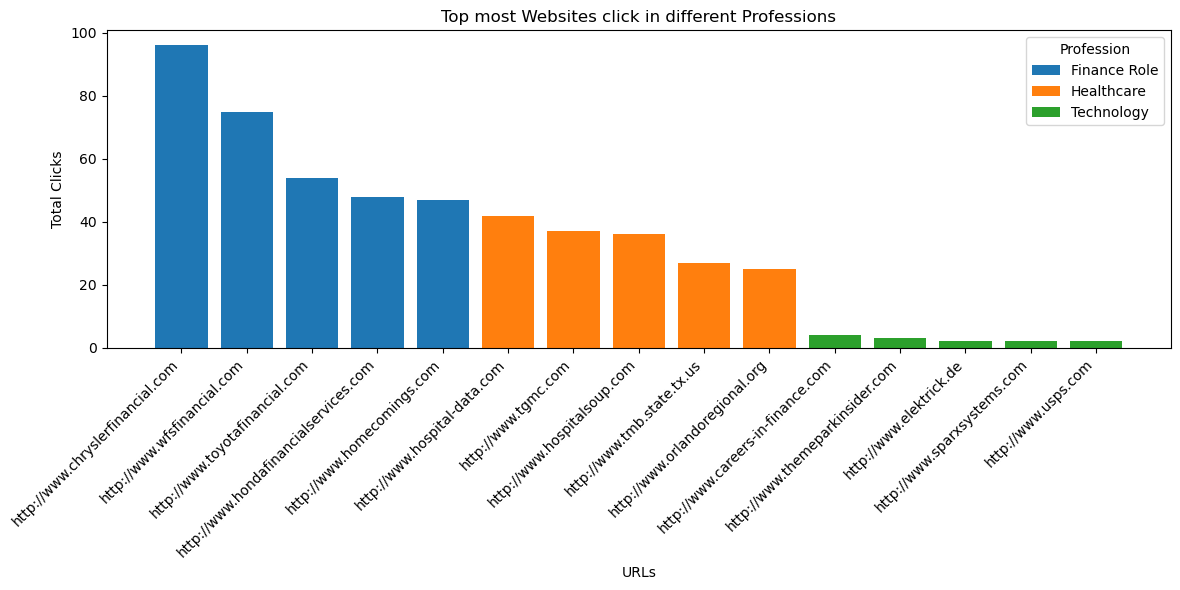

In [95]:
import pandas as pd
import matplotlib.pyplot as plt


# Remove the 'OTHERS' profession
df_filtered = df[df['profession'] != 'OTHERS']

# Plotting
plt.figure(figsize=(12, 6))

# Loop through each profession and plot its URLs
for profession in df_filtered['profession'].unique():
    sub_df = df_filtered[df_filtered['profession'] == profession]
    plt.bar(sub_df['url'], sub_df['total_clicks'], label=profession)

# Customize the chart
plt.xlabel('URLs')
plt.ylabel('Total Clicks')
plt.title('Top most Websites click in different Professions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Profession')
plt.tight_layout()

# Show the plot
plt.show()


## Question 5

In [10]:
query5='''
WITH ProfessionClicks AS (
    select 
profession,
anon.anonid,
count(click) total_clicks
from facts fa
left join (
			select
			id url_id, 
			url
			from urldim
) url on (fa.urlid = url.url_id)
left join (
			select id prof_id,
			CASE
				WHEN UPPER(query) LIKE '%DEVELOPER%' OR 
            		 UPPER(query) LIKE '%PROGRAMMER%'
				THEN 'Technology'
				WHEN 
            		 UPPER(query) LIKE '%PHARMACIST%' OR 
            		 UPPER(query) LIKE '%MEDICAL%'
				THEN 'Healthcare'	
				WHEN UPPER(query) LIKE '%ACCOUNTANT%' OR 
            		 UPPER(query) LIKE '%FINANCIAL%' 
				THEN 'Finance Role'
				ELSE 'OTHERS'
			END PROFESSION
			from querydim
) qu on (fa.queryid = qu.prof_id)
LEFT JOIN (
			select id,
			anonid
			from anondim
) anon  on (fa.anonid = anon.id)
where irank <20
group by  (profession,anon.anonid)
),
RankedClicks AS (
    SELECT 
        profession,
        anonid,
        total_clicks,
        ROW_NUMBER() OVER (PARTITION BY profession ORDER BY total_clicks DESC) AS rank
    FROM 
        ProfessionClicks
)
SELECT 
    profession,
    anonid,
    total_clicks
FROM 
    RankedClicks
WHERE 
    rank <= 5;

'''
df = pd.read_sql_query(query5, conn)

C:\Users\Usman Awan\AppData\Local\Temp\ipykernel_2372\1815419157.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query5, conn)


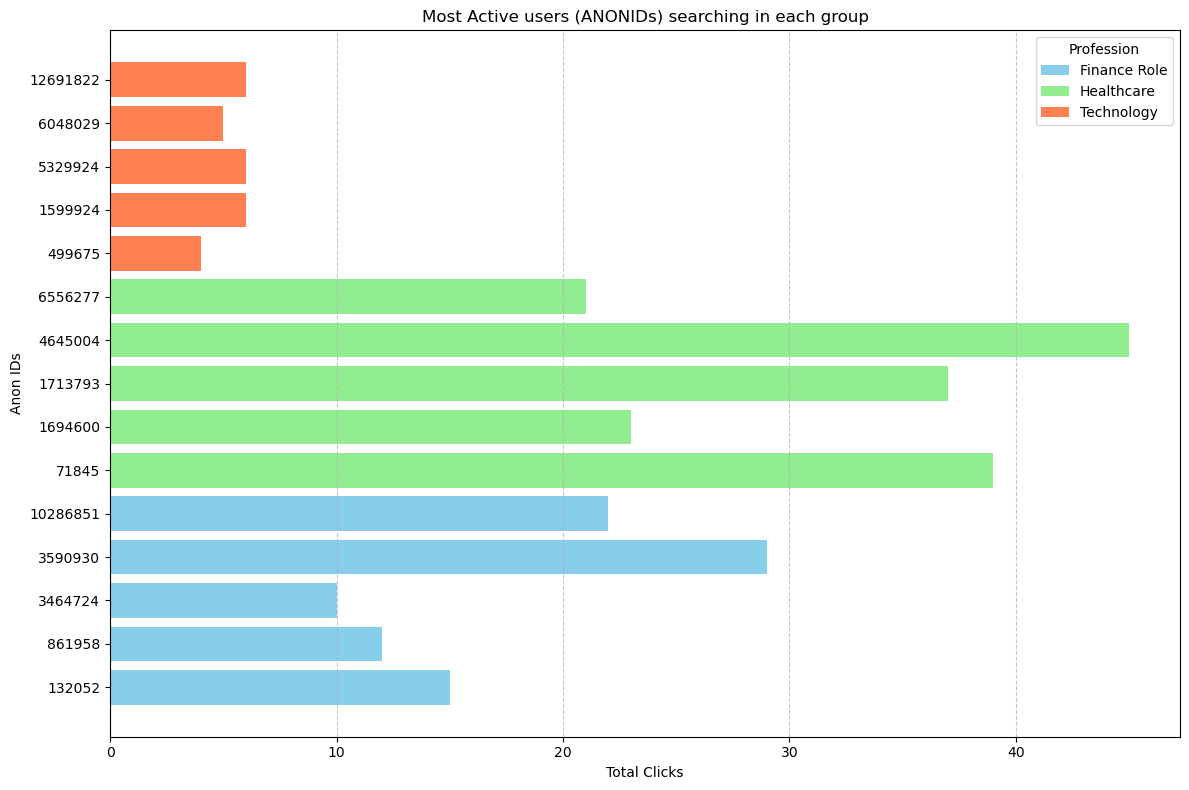

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
# Filter out rows where profession is "OTHERS"
filtered_df = df[df['profession'] != "OTHERS"]

# Sort data by profession
filtered_df = filtered_df.sort_values(by=["profession", "anonid"])

# Assign unique colors to each profession
colors = {"Finance Role": "skyblue", "Healthcare": "lightgreen", "Technology": "coral"}

# Group data by profession for plotting
groups = filtered_df.groupby("profession")

# Plot settings
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.8

# Create y-ticks for each anonid, grouped by profession
positions = []
labels = []
current_pos = 0
for profession, group in groups:
    positions.extend(range(current_pos, current_pos + len(group)))
    labels.extend(group["anonid"].astype(str))
    ax.barh(
        range(current_pos, current_pos + len(group)),
        group["total_clicks"],
        bar_width,
        label=profession,
        color=colors[profession],
    )
    current_pos += len(group)

# Add labels, legend, and grid
ax.set_yticks(positions)
ax.set_yticklabels(labels)
ax.set_xlabel("Total Clicks")
ax.set_ylabel("Anon IDs")
ax.set_title("Most Active users (ANONIDs) searching in each group")
ax.legend(title="Profession", loc="upper right")
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
